In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
import cv2
import time
import random
import itertools
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import tensorflow_hub as hub

from PIL import Image
from datetime import datetime
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [2]:
train_images_path ='../input/plant-pathology-2021-fgvc8/train_images/'
test_images_path = '../input/plant-pathology-2021-fgvc8/test_images/'
train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv', dtype=str)
train.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [3]:
train.shape

(18632, 2)

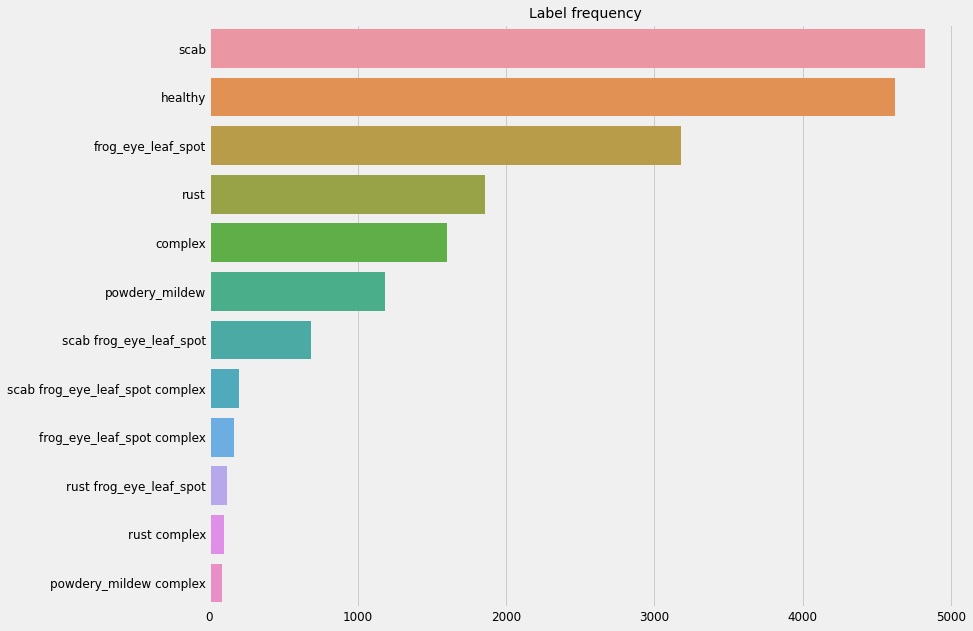

In [4]:
# Get label frequencies in descending order
label_freq = train['labels'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [5]:
label_freq

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [6]:
# Transform labels into a list of labels
train['new_labels'] = train['labels'].apply(lambda s: [l for l in str(s).split()])
train.head()

,image,labels,new_labels
0,800113bb65efe69e.jpg,healthy,[healthy]
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,scab,[scab]
3,80077517781fb94f.jpg,scab,[scab]
4,800cbf0ff87721f8.jpg,complex,[complex]


In [7]:
train_paths = [os.path.join(train_images_path, str(f)) for f in train['image']]
corresponding_labels = [f for f in train['new_labels']]

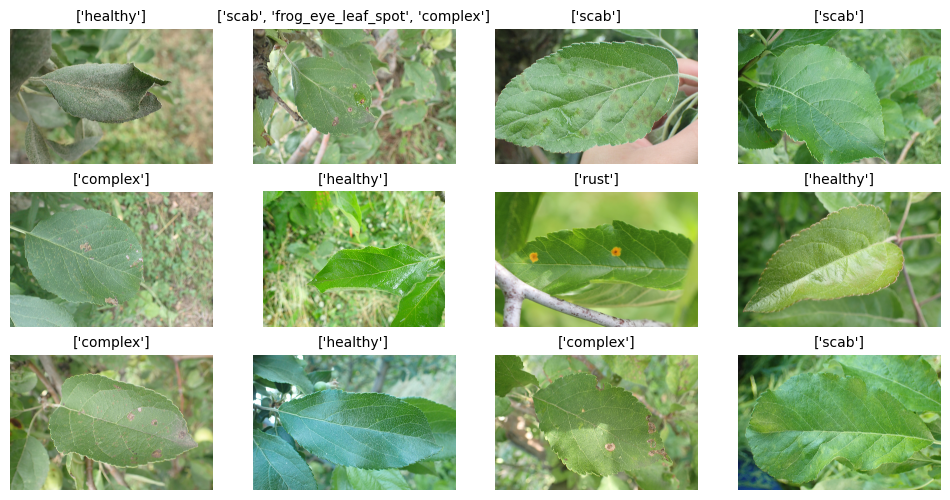

In [8]:
nobs = 14 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,2*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(train_paths[i]))
    plt.title(corresponding_labels[i], size=10)
    plt.axis('off')

In [9]:
#Label Encoding
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(train['new_labels'])

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. complex
1. frog_eye_leaf_spot
2. healthy
3. powdery_mildew
4. rust
5. scab


In [10]:
# transform the new_labels to one-hot encoding 
df = pd.DataFrame(mlb.fit_transform(train['new_labels']),columns=mlb.classes_)
# Place the DataFrames side by side
new_df = pd.concat([train,df],axis=1)

In [11]:
new_df

,image,labels,new_labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,healthy,[healthy],0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]",1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,scab,[scab],0,0,0,0,0,1
3,80077517781fb94f.jpg,scab,[scab],0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,complex,[complex],1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
18627,fffb900a92289a33.jpg,healthy,[healthy],0,0,1,0,0,0
18628,fffc488fa4c0e80c.jpg,scab,[scab],0,0,0,0,0,1
18629,fffc94e092a59086.jpg,rust,[rust],0,0,0,0,1,0
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot,"[scab, frog_eye_leaf_spot]",0,1,0,0,0,1


In [12]:
columns = list(mlb.classes_)
columns

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [13]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [14]:
base_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                           validation_split=0.2,
                                                           samplewise_center=True,
                                                           samplewise_std_normalization=True,
                                                           horizontal_flip=True, 
                                                           vertical_flip=False,
                                                           height_shift_range=0.05,
                                                           width_shift_range=0.1,
                                                           #rotation_range=20,
                                                           shear_range=0.1,
                                                           fill_mode='reflect',
                                                           zoom_range=0.15)

train_gen=base_gen.flow_from_dataframe(dataframe=new_df,
                                             directory=train_images_path,
                                             x_col='image',
                                             y_col='new_labels',
                                             batch_size=32,
                                             seed=42,
                                             shuffle=True,
                                             #class_mode='raw',
                                             class_mode='categorical',
                                             classes=columns,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='training')


valid_gen=base_gen.flow_from_dataframe(dataframe=new_df,
                                             directory=train_images_path,
                                             x_col='image',
                                             y_col='new_labels',
                                             batch_size=32,
                                             seed=42,
                                             shuffle=True,
                                             #class_mode='raw',
                                             class_mode='categorical',
                                             classes=columns,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='validation')

Found 14906 validated image filenames belonging to 6 classes.
Found 3726 validated image filenames belonging to 6 classes.


In [15]:
# feature_extractor_url ='https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
# feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
#                                          input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS),
#                                         trainable=False)

In [16]:
# model = tf.keras.Sequential([
#     feature_extractor_layer,
#     layers.Dense(1024, activation='relu', name='hidden_layer'),
#     layers.Dense(N_LABELS, activation='sigmoid', name='output')
# ])

# model.summary()

In [17]:

# #our custom model starts here (sequential)
# model =tf.keras.Sequential(
#     [
#         layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', 
#                       input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),
#         layers.BatchNormalization(axis=3),
#         layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.BatchNormalization(axis=3),
#         layers.Dropout(0.25),
        
#         layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
#         layers.BatchNormalization(axis=3),
#         layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.BatchNormalization(axis=3),
#         layers.Dropout(0.25),
        
#         layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'),
#         layers.BatchNormalization(axis=3),
#         layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.BatchNormalization(axis=3),
#         layers.Dropout(0.5),
        
#         layers.Flatten(),
        
#         layers.Dense(512), # Fully connected layer
#         layers.BatchNormalization(),
#         layers.Dropout(0.5),
        
# #         layers.Dense(60, activation="relu"),  # Fully connected layer
# #         layers.BatchNormalization(),
# #         layers.Dropout(0.5),
        
#         layers.Dense(N_LABELS, activation="sigmoid")  # Classification layer or output layer
#     ]
# )

# # model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0005), 
# #               loss=tf.keras.metrics.binary_crossentropy,
# #               metrics=['binary_accuracy', 'mae'])

# model.summary()




In [18]:
### Toy ResNet Model

### Toy ResNet Model

In [19]:
inputs = tf.keras.Input(shape=(224, 224, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(N_LABELS)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 32) 896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 73, 73, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
#Learning rate & loss specified in Base paper
optimizer = [tf.keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.9, beta_2=0.999), 
             tf.keras.optimizers.Adagrad(),
             tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
             tf.keras.optimizers.Adadelta(),
             tf.keras.optimizers.RMSprop(),
             tf.keras.optimizers.Nadam()]

model.compile(optimizer=optimizer[0], loss="binary_crossentropy", metrics=['binary_accuracy'])

In [21]:
# set up a checkpoint for model training
# https://keras.io/callbacks/
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights.best.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only = True)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,mode='auto') 
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=4,mode='auto')

callbacks_list = [checkpointer,reduce,early]

In [22]:
valid_X, valid_Y = next(valid_gen)
history = model.fit(train_gen,validation_data=(valid_X,valid_Y),callbacks=callbacks_list,epochs=2)

Epoch 1/2
466/466 [==============================] - 2859s 6s/step - loss: 0.5790 - binary_accuracy: 0.8122 - val_loss: 0.4036 - val_binary_accuracy: 0.8229

Epoch 00001: val_loss improved from inf to 0.40359, saving model to weights.best.01-0.40.hdf5
Epoch 2/2
466/466 [==============================] - 2630s 6s/step - loss: 0.4414 - binary_accuracy: 0.8156 - val_loss: 0.4466 - val_binary_accuracy: 0.8229

Epoch 00002: val_loss did not improve from 0.40359


plotting started
still ploting
plotting finishing


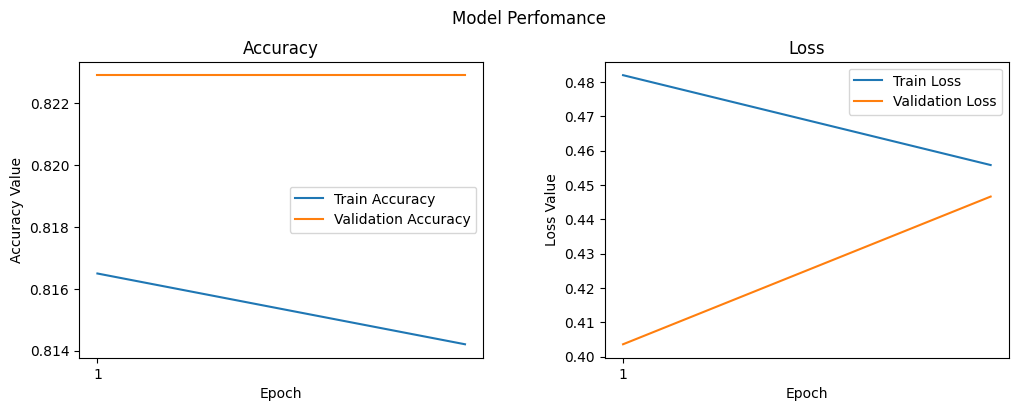

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Model Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
print("plotting started")
max_epoch = len(history.history['binary_accuracy']) + 1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['binary_accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_binary_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
ax1.figure.savefig("Accuracy.png")

print("still ploting")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
ax2.figure.savefig("plot.png")

print("plotting finishing")

In [24]:
def  prediction(image_name, model):
    
    img_path = os.path.join(test_images_path, image_name)

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    #img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    print(model.predict(img))
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values
    predicted_labels = ' '.join(prediction)
    
    return predicted_labels
    

In [25]:
submission_df = pd.DataFrame(columns=['image','labels'])

for image_name in os.listdir(test_images_path):
    predicted_labels = prediction(image_name,model)
    submission_df=submission_df.append(pd.DataFrame({'image':[image_name],'labels':[predicted_labels]}))
submission_df

[[ 5.426786    1.1901871   0.21330261 -3.291447    6.572888    0.87908566]]
[[ 5.0777345  1.2954224  1.6282489 -2.924819   5.496318   1.8409078]]
[[ 3.337994    0.7021971  -0.51953375 -2.2606754   4.2538204   0.12543926]]


,image,labels
0,ad8770db05586b59.jpg,complex frog_eye_leaf_spot rust scab
0,c7b03e718489f3ca.jpg,complex frog_eye_leaf_spot healthy rust scab
0,85f8cb619c66b863.jpg,complex frog_eye_leaf_spot rust


In [26]:
submission_df.to_csv('/kaggle/working/submission.csv', index=False)